<font face="B Mitra" size=4>
<div dir=rtl align=center>
<br>
<img src="https://aut.ac.ir/templates/tmpl_modern01/images/logo_fa.png" alt="Amirkabir University Logo" width="100">
<br>
<font size=6>
<b>پروژه سوم داده کاوی</b>
<br>
<b><font size=5> استاد درس: دکتر فاطمه شاکری</b>
<hr>
</div>
</font>

<font face="B Mitra">
<div dir=rtl>
<font size=5>
کتابخانه های موردنیاز را در این بخش بارگذاری کنید.
</p>
</font>
</div>
</font>

In [ ]:
!pip install langdetect
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz (531.2 MB)
  Preparing metadata (setup.py) ... done


<font face="B Mitra">
<div dir=rtl>
<font size=5>
نصب پکیج <code>spacy</code> ممکن است وابسته به سیستم‌عامل و پکیج‌منیجر شما نیاز به دستوری متفاوت داشته‌باشد. دستور مناسب را می‌تواند با استفاده از
<a href="https://spacy.io/usage">این لینک</a> بیابید.
</p>
</font>
</div>
</font>

In [1]:
import spacy
import numpy as np
import pandas as pd
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [2]:
# Plotting and visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

# Used to draw a progress bar for longer method calls
from tqdm import tqdm

# Used to detect language used in each document
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

# Pre-trained natural language processing pipeline for biomedical use
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

# Used to import list of punctuations
import string

# Feature extraction (text vectorizers)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering and evaluation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> لود کردن مجموعه داده </b>
<br>
<p align="justify">
<font size=5>
فایل مجموعه داده در <a href="https://drive.google.com/file/d/15E8FLX0C-6qpK-lDBEQJXw00Lsdcvjae/view?usp=sharing">گوگل درایو</a> در اختیار شما قرار گرفته است:
<br>
همچنین در صورت استفاده از گوگل کولب با استفاده از دستور زیر میتوانید مجموعه داده را از گوگل درایو در نوتبوک خود دانلود کنید.
</p>
</font>
</div>
</font>

!gdown 15E8FLX0C-6qpK-lDBEQJXw00Lsdcvjae

In [ ]:
!gdown 15E8FLX0C-6qpK-lDBEQJXw00Lsdcvjae

Downloading...
From (original): https://drive.google.com/uc?id=15E8FLX0C-6qpK-lDBEQJXw00Lsdcvjae
From (redirected): https://drive.google.com/uc?id=15E8FLX0C-6qpK-lDBEQJXw00Lsdcvjae&confirm=t&uuid=0ba7b6d6-e753-4fd8-96b6-afc9b32cae17
To: /content/10k_df.csv
100% 341M/341M [00:03<00:00, 90.0MB/s]


<font face="B Mitra">
<div dir=rtl>
<font size=5>
در شروع کار،دیتافریم موردنظر خود را ایجاد کردیم و مقادیر خالی را با space جایگزین کردیم.
دلیل این کار جلوگیری از خطا در مصورسازی انتهایی است.<br>
سپس با توجه به زمانبر بودن اجرا،حداقل یک سمپل 1500 تایی نمونه برداری کردیم.
<br>
برای کسب نتایج بهتر و مصورسازی مناسبتر میتوانیم تعداد سمپل را افزایش دهیم.
</p>
</font>
</div>

In [3]:
df_10k = pd.read_csv('10k_df.csv')

In [4]:
df_10k.fillna(value=" ",inplace=True)

In [5]:
df = df_10k.sample(1500, random_state=42)
del df_10k

<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> پیش پردازش متن</b>
<br>
<p align="justify">
<font size=5>
 برای پیش پردازش متون از کتابخانه های مختلفی از جمله NLTK ،Gensim یا Spacy میتوان استفاده کرد.
 <br>
 مواردی که در پیش پردازش متون باید به آن توجه کرد.
 <ol>
 <br>
 <li> <b>تشخیص زبان مورداستفاده مقاله ها:</b>
  در این مجموعه داده میتوانید  با استفاده از کتابخانه langdetect زبان مورد استفاده مقاله را در ویژگی <code>body_text</code> بررسی کنید.
 با توجه به نتیجه نهایی خواهید دید که زبان انگلیسی زبان غالب در این مقاله هاست بنابراین میتوان مقاله های غیر انگلیسی را حذف کرد.
 </li>
 <li> <b>توکنایز کردن (Tokenize) مدل ها:</b>
 در این مجموعه داده از  پایپ لاین  <code>en_core_sci_lg</code> از کتابخانه  spaCy به دلیلی پشتبانی از داده های زیستی و پزشکی و با بردارهای 600 هزار کلمه ای و واژگان بزرگتر میتوانیم استفاده کنیم.<br>
 به دلیل اینکه SpaCy حداکثر یک میلیون کاراکتر را بررسی میکند میتوان با استفاده از max_length این محدودیت را کاهش داد:
 لطفا از parser مشخص شده در بخش زیر برای توکنایز کردن متن خود استفاده کنید.


 </li>
 <li> <b> Lemmatization یا Stemming (ریشه یابی) </b>
 </li>
 <li> <b>حذف Stopwords</b> </li>
 <li> <b>حذف علائم نشانه گذاری</b> </li>
 </ol>
<br>
درمورد هر یک از موارد بالا جستجو کنید و پیش پردازش های لازم را برای ویژگی "body text" مقاله انجام دهید.
</p>
</font>
</div>
</font>

<div dir=rtl>

<font color='yellow'>
کد زیر وظیفه شناسایی زبان مقالات موجود در یک
 DataFrame و حذف
مقالاتی که به زبان انگلیسی نیستند را انجام می‌دهد.
<br>
<font color='yellow'>
این خط کد، مقدار بذر (seed) را برای تولید اعداد تصادفی در کتابخانه تشخیص زبان `langdetect` تنظیم می‌کند. تنظیم بذر باعث می‌شود که نتایج تشخیص زبان در اجرای‌های مختلف یکسان باشند.
<br>
<font color='yellow'>
 تابع `detect_language` برای شناسایی زبان متن ورودی (پارامتر `text`) استفاده می‌شود. در صورت بروز خطا (به عنوان مثال، در صورتی که متن قابل تشخیص نباشد)، مقدار "unknown" برگردانده می‌شود.
<br>
<font color='yellow'>
در این خط، ستون جدیدی به نام `language` به DataFrame `df` اضافه می‌شود. برای هر ردیف از DataFrame، تابع `detect_language` بر روی ستون `body_text` اعمال می‌شود و زبان متن شناسایی شده در ستون جدید `language` قرار می‌گیرد.
<br>
<font color='yellow'>
در نهایت، این خط مقالاتی که زبان آن‌ها انگلیسی نیست را حذف می‌کند و فقط مقالاتی که زبان آن‌ها "en" (انگلیسی) است، باقی می‌مانند.

</div>

In [6]:
# تثبیت تصادفی برای تکرارپذیری نتایج
DetectorFactory.seed = 0

# تابعی برای شناسایی زبان متن
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# شناسایی زبان هر مقاله و اضافه کردن آن به یک ستون جدید
df['language'] = df['body_text'].apply(detect_language)

# حذف مقالاتی که زبان آن‌ها انگلیسی نیست
df = df[df['language'] == 'en']

In [7]:
df

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language
6252,fefd6cdcddcb00d1ba2ef1a0d3bba9f312010a1d,10.1111/j.1524-4733.2008.00379.x,,China is the biggest country in the world that...,"Li, Youing. Sun, Xin. Wang, Li",Evidence-Based Medicine in China,Value in Health,Not provided.,en
4684,2a3d080d5dcf6771db002366691f35e5d6f0e493,10.1007/s13238-010-0029-7,,"✉ Correspondence: zlshi@wh.iov.cn Bat, the onl...","Shi, Zhengli",Bat and virus,Protein & Cell,Not provided.,en
1731,2de657aabab331e75657bfc1443542fd345b6f26,10.1016/j.ccc.2019.06.001,KEYWORDS\nPandemic Influenza Disaster prepared...,Outbreaks of infectious disease pose unique ch...,"Maves, Ryan C.. Jamros, Christina M.. Smith...",Intensive Care Unit Preparedness During<br>Pa...,Crit Care Clin,KEYWORDS\nPandemic Influenza Disaster<br>prep...,en
4742,bc22758234283f024f16e2dbe660bc909b512b92,10.1016/j.vetpar.2007.11.020,Cryptosporidium parvum is recognized as one of...,Diarrhoeal diseases of infectious aethiology r...,"Klein, Pavel. Kleinová, Tereza. Volek,<br>Z...",Effect of Cryptosporidium parvum infection on...,Veterinary Parasitology,Cryptosporidium parvum is recognized as one o...,en
4521,a204aafa38365dbcc0a26af3ca2c6d3313d7fab2,10.1111/irv.12518,", Brazil, in the period of Background: The res...",The inclusion criteria for asymptomatic adults...,"Moreira, Luciana Peniche. Watanabe, Aripuana...",Respiratory syncytial virus evaluation among<...,Influenza Other Respir Viruses,", Brazil, in the period of Background: The<br...",en
...,...,...,...,...,...,...,...,...,...
967,e021d75c9a2c8f02f80ccfbad4133b15d1777576,10.1038/sj.eye.6701885,Many new infectious diseases in humans have be...,Severe acute respiratory syndrome (SARS) is th...,"Chan, W-M. Liu, D T L. Chan, P K S. Chong,...",Precautions in ophthalmic practice in a<br>ho...,Eye (Lond),Many new infectious diseases in humans have<b...,en
6043,24beb94c313a07be6b0c745a6ca8a3d810618506,,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome (MERS) is...,"Ozharovskaia, T. A.. Zubkova, O. V.. <br>Dol...",Immunogenicity of Different Forms of Middle<b...,Acta Naturae,The Middle East respiratory syndrome<br>coron...,en
6879,94475eaa419b11d7edf53c2fe4e423acef0ce881,10.12688/wellcomeopenres.15718.1,The current novel coronavirus outbreak appears...,The ongoing outbreak of novel Coronavirus appe...,"Abbott, Sam. Hellewell, Joel. Munday, James...",The transmissibility of novel Coronavirus in<...,Wellcome Open Res,The current novel coronavirus outbreak<br>app...,en
6775,a6ab8b27158a48683b4fa6d081614cde9087cc5e,10.1016/j.bja.2020.05.002,,Editor -The critical shortage of medical suppl...,"Lang, Angela L.. Shaw, Kendrick M.. Lozano,...",Effectiveness of a negative-pressure patient<...,Br. j. anaesth,Not provided.,en


<div dir=rtl>
<font color='yellow'>
توکنایز کردن (Tokenization) یکی از مراحل اولیه پردازش زبان طبیعی (NLP) است و به معنای شکستن یک متن به واحدهای کوچکتر (توکن‌ها) است. این واحدهای کوچکتر معمولاً شامل کلمات، عبارات، جملات یا حتی کاراکترها می‌باشند، بسته به نوع توکنایز کردن و کاربرد آن.
با استفاده از مدل‌های spaCy،توکن‌ها به کلمات و نشانه‌ها تقسیم می‌شوند که می‌تواند برای تحلیل‌های بعدی استفاده شود.
</div>

<div dir=rtl>
<font color='yellow'>
Lemmatization یک فرآیند پردازش متن است که به ازای هر کلمه، شکل اصلی آن را استخراج می‌کند. در این فرآیند، کلمات به شکل استاندارد یا ریشه‌ی کلی خود بازنویسی می‌شوند. به عبارت دیگر، Lemmatization به ما کمک می‌کند تا از کلمات در قالب استاندارد و یکتا استفاده کنیم، بدون توجه به شکل‌های مختلف و تغییرات گرامری ممکن.
<br>
<font color='yellow'>
کاربرد اصلی Lemmatization در پردازش متن و پردازش زبان طبیعی است. با استفاده از لمات‌های استاندارد، می‌توانیم تحلیل متن، خوشه‌بندی، جستجو و دسته‌بندی موثرتری انجام دهیم. همچنین، این فرآیند می‌تواند بهبود مدل‌های پردازش متن و مدل‌های یادگیری ماشین کمک کند، زیرا باعث کاهش ابهامات و تفاوت‌های گرامری در داده‌ها می‌شود.

</div>

<div dir=rtl>
<font color='yellow'>
حذف Stopwords و علائم نشانه‌گذاری (Punctuation) دو مرحله مهم در پیش‌پردازش داده‌های متنی هستند. این مراحل به بهبود عملکرد مدل‌های پردازش زبان طبیعی (NLP) کمک می‌کنند.
<br>
<font color='yellow'>
stopwords:کلماتی هستند که به تنهایی اطلاعات خاصی ارائه نمی‌دهند و برای درک کلی متن ضروری نیستند. این کلمات شامل کلماتی مانند "و"، "به"، "از"، "است" و غیره هستند
<br>
<font color='yellow'>
کاربرد حذف Stopwords:
- **کاهش حجم داده:** با حذف کلمات غیرمفید، حجم داده کاهش می‌یابد که منجر به بهبود کارایی و سرعت پردازش می‌شود.
- **بهبود دقت مدل‌ها:** حذف کلمات غیرمفید کمک می‌کند تا مدل‌های NLP بر روی کلمات و مفاهیم مهم‌تر تمرکز کنند، که می‌تواند دقت مدل را افزایش دهد.
- **کاهش نویز:** Stopwords می‌توانند به عنوان نویز در داده‌ها عمل کنند و مدل‌ها را گمراه کنند. حذف آن‌ها به کاهش این نویز کمک می‌کند.
<br>
<font color='yellow'>
حذف علائم نشانه‌گذاری (Punctuation)
<br>
<font color='yellow'>
علائم نشانه‌گذاری شامل کاراکترهایی مانند نقطه، ویرگول، علامت سوال و غیره هستند. این کاراکترها معمولاً برای تجزیه و تحلیل معنایی متن ضروری نیستند.
<br>
<font color='yellow'>
 کاربرد حذف علائم نشانه‌گذاری:
- **ساده‌سازی متن:** حذف علائم نشانه‌گذاری باعث ساده‌تر شدن متن و کاهش پیچیدگی آن می‌شود.
- **استخراج بهتر ویژگی‌ها:** بسیاری از مدل‌های NLP به جایگزینی و یا حذف علائم نشانه‌گذاری نیاز دارند تا بتوانند ویژگی‌های مهم‌تر متن را استخراج کنند.
- **بهبود دقت مدل‌ها:** همانند حذف Stopwords، حذف علائم نشانه‌گذاری نیز به کاهش نویز و افزایش دقت مدل کمک می‌کند.
</div>

In [8]:
import nltk

# دانلود مجموعه stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/sina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<div dir=rtl>
<font color='yellow'>
کد زیر فرآیند پیش‌پردازش متون در یک DataFrame را انجام می‌دهد. این فرآیند شامل توکنایز کردن، Lemmatization، حذف Stopwords و حذف علائم نشانه‌گذاری است. در نهایت، متون پردازش شده در یک ستون جدید ذخیره می‌شوند. در ادامه به توضیح جزئیات هر قسمت از کد می‌پردازیم:
<br>
<font color='yellow'>
- وارد کردن کتابخانه‌های لازم: `stopwords` از `NLTK`، `re` برای عملیات مربوط به عبارات باقاعده، و `word_tokenize` برای توکنایز کردن.
- بارگذاری مدل بزرگ انگلیسی علمی `spaCy` (`en_core_sci_lg`) برای استفاده از Lemmatization. اجزای `tagger` و `ner` غیرفعال شده‌اند تا سرعت پردازش افزایش یابد. حداکثر طول ورودی برای مدل به 3,000,000 کاراکتر افزایش یافته است.
<br>
<font color='yellow'>
لیست Stopwords انگلیسی از `NLTK` بارگذاری شده و به مجموعه‌ای تبدیل می‌شود تا دسترسی به آن سریع‌تر باشد.
<br>
<font color='yellow'>
 تابع `tokenize_and_lemmatize`، متن ورودی را توکنایز کرده و برای هر توکن Lemmatization انجام می‌دهد. خروجی این تابع لیستی از(شکل‌های پایه) توکن‌ها است.
<br>
<font color='yellow'>
 تابع `remove_stopwords`، توکن‌هایی که در مجموعه Stopwords هستند را از لیست توکن‌ها حذف می‌کند.
<br>
<font color='yellow'>
 تابع `remove_punctuation`، علائم نشانه‌گذاری را از توکن‌ها حذف می‌کند.
<br>
<font color='yellow'>
سپس، برای هر متن در ستون `body_text`، تابع `tokenize_and_lemmatize` اعمال شده و نتیجه در ستون جدید `tokens` ذخیره می‌شود.
<br>
<font color='yellow'>
توکن‌های ذخیره شده در ستون `tokens`نیز بررسی شده و  Stopwords حذف می‌شوند.
سپس
علائم نشانه‌گذاری از توکن‌های موجود در ستون `tokens` حذف می‌شوند.
<br>
<font color='yellow'>
در نهایت، توکن‌های پردازش شده با استفاده از فاصله به یک رشته ترکیب شده و نتیجه در ستون جدید `processed_text` ذخیره می‌شود.
</div>

In [9]:
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize

# بارگذاری مدل spaCy برای استفاده از Lemmatization با غیر فعال کردن برخی اجزا
parser = spacy.load("en_core_sci_lg", disable=["tagger", "ner"])
parser.max_length = 3000000

# لیست Stopwords انگلیسی از NLTK
stop_words = set(stopwords.words('english'))

# تابعی برای توکنایز کردن و اعمال Lemmatization بر روی متن
def tokenize_and_lemmatize(text):
    doc = parser(text)
    return [token.lemma_ for token in doc]

# تابعی برای حذف Stopwords از لیست توکن‌ها
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# تابعی برای حذف علائم نشانه‌گذاری از لیست توکن‌ها
def remove_punctuation(tokens):
    return [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)]

# اعمال توکنایز کردن و Lemmatization بر روی فیچر body_text
df['tokens'] = df['body_text'].apply(tokenize_and_lemmatize)

# حذف Stopwords
df['tokens'] = df['tokens'].apply(remove_stopwords)

# حذف علائم نشانه‌گذاری
df['tokens'] = df['tokens'].apply(remove_punctuation)

# ترکیب توکن‌ها به یک رشته و ذخیره نتیجه در یک ستون جدید به نام processed_text
df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

/home/sina/Desktop/dm_proj_3/venv/lib/python3.10/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]
/home/sina/Desktop/dm_proj_3/venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [10]:
df

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,tokens,processed_text
6252,fefd6cdcddcb00d1ba2ef1a0d3bba9f312010a1d,10.1111/j.1524-4733.2008.00379.x,,China is the biggest country in the world that...,"Li, Youing. Sun, Xin. Wang, Li",Evidence-Based Medicine in China,Value in Health,Not provided.,en,"[china, biggest, country, world, 13, billion, ...",china biggest country world 13 billion populat...
4684,2a3d080d5dcf6771db002366691f35e5d6f0e493,10.1007/s13238-010-0029-7,,"✉ Correspondence: zlshi@wh.iov.cn Bat, the onl...","Shi, Zhengli",Bat and virus,Protein & Cell,Not provided.,en,"[correspondence, zlshiwhiovcn, bat, flying, ma...",correspondence zlshiwhiovcn bat flying mammal ...
1731,2de657aabab331e75657bfc1443542fd345b6f26,10.1016/j.ccc.2019.06.001,KEYWORDS\nPandemic Influenza Disaster prepared...,Outbreaks of infectious disease pose unique ch...,"Maves, Ryan C.. Jamros, Christina M.. Smith...",Intensive Care Unit Preparedness During<br>Pa...,Crit Care Clin,KEYWORDS\nPandemic Influenza Disaster<br>prep...,en,"[outbreaks, infectious, disease, pose, unique,...",outbreaks infectious disease pose unique chall...
4742,bc22758234283f024f16e2dbe660bc909b512b92,10.1016/j.vetpar.2007.11.020,Cryptosporidium parvum is recognized as one of...,Diarrhoeal diseases of infectious aethiology r...,"Klein, Pavel. Kleinová, Tereza. Volek,<br>Z...",Effect of Cryptosporidium parvum infection on...,Veterinary Parasitology,Cryptosporidium parvum is recognized as one o...,en,"[diarrhoeal, diseases, infectious, aethiology,...",diarrhoeal diseases infectious aethiology repr...
4521,a204aafa38365dbcc0a26af3ca2c6d3313d7fab2,10.1111/irv.12518,", Brazil, in the period of Background: The res...",The inclusion criteria for asymptomatic adults...,"Moreira, Luciana Peniche. Watanabe, Aripuana...",Respiratory syncytial virus evaluation among<...,Influenza Other Respir Viruses,", Brazil, in the period of Background: The<br...",en,"[inclusion, criteria, asymptomatic, adults, ab...",inclusion criteria asymptomatic adults absence...
...,...,...,...,...,...,...,...,...,...,...,...
967,e021d75c9a2c8f02f80ccfbad4133b15d1777576,10.1038/sj.eye.6701885,Many new infectious diseases in humans have be...,Severe acute respiratory syndrome (SARS) is th...,"Chan, W-M. Liu, D T L. Chan, P K S. Chong,...",Precautions in ophthalmic practice in a<br>ho...,Eye (Lond),Many new infectious diseases in humans have<b...,en,"[severe, acute, respiratory, syndrome, sars, m...",severe acute respiratory syndrome sars modern ...
6043,24beb94c313a07be6b0c745a6ca8a3d810618506,,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome (MERS) is...,"Ozharovskaia, T. A.. Zubkova, O. V.. <br>Dol...",Immunogenicity of Different Forms of Middle<b...,Acta Naturae,The Middle East respiratory syndrome<br>coron...,en,"[middle, east, respiratory, syndrome, mers, ac...",middle east respiratory syndrome mers acute in...
6879,94475eaa419b11d7edf53c2fe4e423acef0ce881,10.12688/wellcomeopenres.15718.1,The current novel coronavirus outbreak appears...,The ongoing outbreak of novel Coronavirus appe...,"Abbott, Sam. Hellewell, Joel. Munday, James...",The transmissibility of novel Coronavirus in<...,Wellcome Open Res,The current novel coronavirus outbreak<br>app...,en,"[ongoing, outbreak, novel, coronavirus, appear...",ongoing outbreak novel coronavirus appears ori...
6775,a6ab8b27158a48683b4fa6d081614cde9087cc5e,10.1016/j.bja.2020.05.002,,Editor -The critical shortage of medical suppl...,"Lang, Angela L.. Shaw, Kendrick M.. Lozano,...",Effectiveness of a negative-pressure patient<...,Br. j. anaesth,Not provided.,en,"[editor, the, critical, shortage, medical, sup...",editor the critical shortage medical supplies ...


<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> استخراج ویژگی </b>
<br>
<p align="justify">
<font size=5>
اکنون که متن بدنهٔ مقاله‌ها را از قبل پردازش کرده‌ایم، زمان تبدیل آن‌ها به قالبی است که توسط الگوریتم‌های ما قابل استفاده باشد. برای این منظور از tf-idf استفاده خواهیم کرد. tf_idf  یک الگوریتم بسیار رایج برای تبدیل متن به نمایش معنی دار اعداد است که اهمیت هر کلمه را در متن موردنظر نشان میدهد. <br>
درمورد عملکرد این روش جستجو کنید.
 برای متن پیش پردازش شده هر مقاله، با استفاده از این روش یک بازنمایی برداری با حداکثر 4096 ویژگی ایجاد کنید.
</p>
</font>
</div>
</font>

<div dir=rtl>

<font color='yellow'>
ماتریس TF-IDF (مخفف Term Frequency-Inverse Document Frequency) یک روش محاسبهٔ وزن و اهمیت واژه‌ها در متن‌ها است. این ماتریس برای تحلیل متون و برداشت اطلاعات مفید از آن‌ها استفاده می‌شود. هدف اصلی TF-IDF، تشخیص واژه‌های مهم در یک متن است.
<br>
<font color='yellow'>
محاسبهٔ ماتریس TF-IDF برای یک مجموعهٔ اسناد شامل دو بخش اصلی است: تعداد تکرار واژه‌ها در هر سند (Term Frequency) و وزن واژه‌ها بر اساس فراوانی ظهور آن‌ها در مجموعهٔ اسناد (Inverse Document Frequency).
<br>
<font color='yellow'>
مراحل محاسبهٔ ماتریس TF-IDF به شرح زیر است:
<br>
<font color='yellow'>
1. تعداد تکرار واژه‌ها (Term Frequency - TF):
   - برای هر سند در مجموعهٔ اسناد، تعداد تکرار هر واژه را محاسبه می‌کنیم. این میزان تکرار می‌تواند به صورت ساده (تعداد تکرار واژه در سند) یا نرمال شده (تعداد تکرار واژه تقسیم بر کل تعداد واژه‌های سند) باشد. هدف از نرمال‌سازی، رفع تأثیر طول سند بر تعداد تکرار واژه‌ها است.
<br>
<font color='yellow'>
2. وزن واژه‌ها بر اساس فراوانی ظهور آن‌ها در مجموعهٔ اسناد (Inverse Document Frequency - IDF):
   - محاسبهٔ تعداد سندهایی که واژه در آن‌ها ظاهر می‌شود (Document Frequency).
   - محاسبهٔ IDF بر اساس نسبت تعداد کل سندها به تعداد سندهایی که واژه در آن‌ها ظاهر می‌شود. به صورت ریاضی: IDF = log(N / DF)، که N تعداد کل سندها و DF تعداد سندهایی است که واژه در آن‌ها ظاهر می‌شود.
<br>
<font color='yellow'>
3. محاسبهٔ مقدار TF-IDF:
   - در این مرحله، مقدار TF را در مقدار IDF ضرب می‌کنیم تا وزن نهایی واژه‌ها در هر سند را بدست آوریم. این کار باعث می‌شود که واژه‌هایی که در تعداد زیادی از سندها تکرار می‌شوند و در همان زمان در تعداد کمی از سندها ظاهر می‌شوند، وزن بالاتری دریافت کنند.
<br>
<font color='yellow'>
در نتیجه، ماتریس TF-IDF یک ماتریس دو بعدی است که در آن ستون‌ها نمایانگر واژه‌ها و سطرها نمایاین ماتریس نشان می‌دهد که هر واژه در هر سند چه میزان اهمیتی دارد. با داشتن ماتریس TF-IDF، می‌توانیم واژه‌های مهم را شناسایی کنیم و از آن‌ها برای تحلیل متون و استخراج اطلاعات مفید استفاده کنیم.
</font>
</div>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ایجاد شیء TF-IDF با حداکثر 4096 ویژگی
tfidf_vectorizer = TfidfVectorizer(max_features=4096)

# اعمال TF-IDF بر روی متن پردازش شده
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# تبدیل ماتریس TF-IDF به یک DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# افزودن شناسه مقاله (در صورت وجود) به DataFrame جدید
if 'article_id' in df.columns:
    tfidf_df['article_id'] = df['article_id']

In [12]:
tfidf_df

,000,0001,001,002,003,005,01,02,03,04,...,zhang,zikv,zone,zoonotic,µl,µm,à1,μgml,μl,μm
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.020887,0.0,0.000000,0.00000,0.0,0.00000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.013104,0.0,0.000000,0.00000,0.0,0.00000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00915,0.000000,0.0,...,0.0,0.0,0.0,0.010851,0.0,0.000000,0.03177,0.0,0.00000,0.000000
4,0.0,0.064294,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.02385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
1450,0.0,0.000000,0.0,0.0,0.0,0.015750,0.015694,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.013512,0.00000,0.0,0.00000,0.000000
1451,0.0,0.000000,0.0,0.0,0.0,0.008087,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.000000
1452,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.082472,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.274997,0.00000,0.0,0.00000,0.049189


<font face="B Mitra"><div dir=rtl>
<font size=6>
<b> PCA </b>
<br>
<p align="justify">
<font size=5>
با توجه به ابعاد بالای هر بردار ویژگی، با استفاده از روش PCA با حفظ 95 درصد واریانس کاهش بعد دهید.
</p>
</font>
</div>

<div dir=rtl>

<font color='yellow'>
این کد برای اعمال تحلیل ترکیب اصلی (PCA) بر روی داده‌های TF-IDF استفاده می‌شود. هدف اصلی آن این است که با استفاده از PCA، بعد داده‌ها را کاهش داده و حداقل 95 درصد از واریانس اولیه را در داده‌ها حفظ کند.
<br>
<font color='yellow'>
در ابتدا، یک شیء PCA با پارامتر `n_components=0.95` ایجاد می‌شود. این بدان معنی است که PCA تا زمانی که تعداد اجزای اصلی (Principal Components) لازم برای حفظ 95 درصد واریانس را بدست آورد، بعد داده‌ها را کاهش می‌دهد.
<br>
<font color='yellow'>
سپس، PCA روی داده‌های `tfidf_df` اعمال می‌شود و نتیجه به صورت تبدیل شده‌ای از داده‌های اصلی TF-IDF در `tfidf_pca` ذخیره می‌شود.
<br>
<font color='yellow'>
سطر بعدی، یک DataFrame جدید به نام `tfidf_pca_df` ایجاد می‌کند که شامل داده‌های تبدیل شده PCA است. نام ستون‌های DataFrame جدید براساس اجزای اصلی تعیین می‌شود.
<br>
<font color='yellow'>
در نهایت، اگر ستون "article_id" در `tfidf_df` وجود داشته باشد، آن را به DataFrame جدید `tfidf_pca_df` اضافه می‌کند. این کار به شما امکان می‌دهد تا شناسه مقاله مرتبط با هر سطر از داده‌های PCA را نگه دارید، در غیر این صورت این بخش رد می‌شود.
<br>
<font color='yellow'>
در کل، این کد بعد از اعمال PCA بر روی داده‌های TF-IDF، نتیجه را در یک DataFrame جدید ذخیره می‌کند که شامل داده‌های کاهش یافته بعد و شناسه مقاله (در صورت وجود) است.
</font>
</div>

In [13]:
# اعمال PCA برای کاهش بعد و حفظ 95 درصد واریانس
pca = PCA(n_components=0.95)
tfidf_pca = pca.fit_transform(tfidf_df.drop(columns=['article_id'], errors='ignore'))

# تبدیل نتایج PCA به DataFrame
pca_columns = [f'PC{i+1}' for i in range(tfidf_pca.shape[1])]
tfidf_pca_df = pd.DataFrame(tfidf_pca, columns=pca_columns)

# افزودن شناسه مقاله (در صورت وجود) به DataFrame جدید
if 'article_id' in tfidf_df.columns:
    tfidf_pca_df['article_id'] = tfidf_df['article_id']

In [14]:
tfidf_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC950,PC951,PC952,PC953,PC954,PC955,PC956,PC957,PC958,PC959
0,0.119723,0.065268,0.079984,-0.236828,0.094082,-0.050585,0.021057,-0.003241,0.217338,0.023047,...,-0.003834,-0.010412,-0.015008,-0.014178,0.009260,-0.007399,0.005691,0.019139,-0.013434,0.003987
1,-0.250730,0.197872,0.307347,0.072249,-0.025709,0.060989,0.115094,-0.066474,-0.098095,0.084825,...,-0.011196,-0.025324,0.001211,-0.005614,-0.018240,0.008457,0.005622,-0.015000,0.001057,-0.003837
2,0.308483,-0.111703,0.184105,-0.105187,0.046082,-0.082734,0.114551,-0.052597,0.140994,0.199613,...,-0.013641,-0.000595,0.005860,0.007949,0.003431,0.016995,0.003550,0.002575,0.015602,-0.015437
3,-0.065622,0.019449,0.054963,0.006037,-0.031733,-0.038565,-0.128199,0.149893,-0.055611,-0.002084,...,-0.018114,-0.010139,0.025610,0.009239,0.026927,0.008300,0.013542,-0.006308,-0.019278,-0.019197
4,0.078273,-0.116391,0.048610,0.019842,-0.245833,-0.015016,0.065274,0.071805,-0.006330,-0.150230,...,0.001311,0.011509,0.013127,0.001453,0.002497,-0.022562,0.001636,-0.000331,-0.008913,-0.015033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.216166,-0.115107,0.100820,-0.048560,0.024996,-0.003196,0.060412,0.006417,-0.032015,0.315736,...,0.001657,-0.006855,-0.018528,-0.018441,0.022852,0.003965,0.005031,-0.009335,-0.002795,-0.000721
1450,-0.161563,-0.081903,-0.180353,-0.014879,0.017919,-0.030956,0.057535,0.219554,-0.067498,0.277966,...,-0.006462,-0.005349,-0.008725,0.015207,0.011005,0.007859,0.010024,-0.022676,-0.010384,0.004823
1451,0.078718,0.087668,-0.026326,-0.115879,-0.032357,0.013690,-0.078774,0.026658,-0.158840,0.014747,...,0.023749,-0.001172,-0.018661,-0.022077,-0.007993,-0.007495,-0.019063,0.017982,-0.003490,-0.022558
1452,0.067811,-0.015062,-0.009813,-0.087383,0.027344,0.041840,-0.130139,0.061009,-0.062142,0.055143,...,0.000533,0.020168,0.011859,0.007951,0.014574,0.007063,0.007196,-0.012238,0.003552,-0.004192


<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> خوشه بندی </b>
<br>
<p align="justify">
<font size=5>
خوشه بندی مقالات تحقیقاتی مشابه با هم می تواند جستجوی انتشارات مرتبط را ساده کند.  در اینجا از روش K-Means برای خوشه بندی استفاده میکنیم.<br>
 با استفاده از روش Elbow Method  از بین تعداد خوشه های داده شده، میتوانید بهترین تعداد خوشه را بیابید.
<br>
تا 30 خوشه این موضوع را مورد بررسی قرار دهید و پس از یافتن تعداد خوشه مناسب، با استفاده از روش K-Means خوشه بندی لازم را برای بردار ویژگی
بدست آماده از مرحلهٔ قبل به کار بگیرید.
<br><b> بخش امتیازی:</b> میتوانید با به کارگیری روش های دیگر خوشه بندی نظیر خوشه بندی سلسه مراتبی یا DBSCAN نتایج را با استفاده از یک معیار ارزیابی مناسب  مقایسه کنید.
</p>
</font>
</div>

<div dir=rtl>

<font color='yellow'>
این کد با استفاده از روش Elbow، تعداد بهینه خوشه‌ها را برای داده‌ها پیدا می‌کند. نمودار Elbow نشان می‌دهد که معیار اعوجاج (distortion) با افزایش تعداد خوشه‌ها چگونه تغییر می‌کند. نقطه‌ای که تغییر معیار اعوجاج به شدت کاهش می‌یابد (شبیه آرنج) به عنوان تعداد بهینه خوشه‌ها در نظر گرفته می‌شود.
<br>
<font color='yellow'>
تعریف لیست distortions و بردار K:
<br>
distortions برای ذخیره معیار اعوجاج (inertia) که معیار خوبی برای ارزیابی کیفیت خوشه‌بندی است، تعریف می‌شود.
K برداری از 1 تا 30 برای تعداد خوشه‌های مختلف است که الگوریتم K-Means با هر یک از این تعداد خوشه‌ها اجرا خواهد شد.
<br>
<font color='yellow'>
اجرای الگوریتم K-Means برای تعداد خوشه‌های مختلف:
<br>
<font color='yellow'>
حلقه for بر روی بردار K اجرا می‌شود و برای هر مقدار k، یک مدل K-Means با تعداد خوشه‌های k ایجاد می‌شود.
مدل K-Means بر روی داده‌های tfidf_pca_df که ستون article_id در آن حذف شده، آموزش داده می‌شود.
مقدار معیار اعوجاج (inertia) مدل آموزش‌دیده با استفاده از kmeanModel.inertia_ استخراج و به لیست distortions اضافه می‌شود.
<br>
<font color='yellow'>
ترسیم نمودار Elbow:
<br>
<font color='yellow'>
نمودار K در مقابل distortions ترسیم می‌شود.
محورهای x و y برچسب‌گذاری می‌شوند.
عنوان نمودار تنظیم می‌شود.
نمودار نمایش داده می‌شود.
<br>
</div>

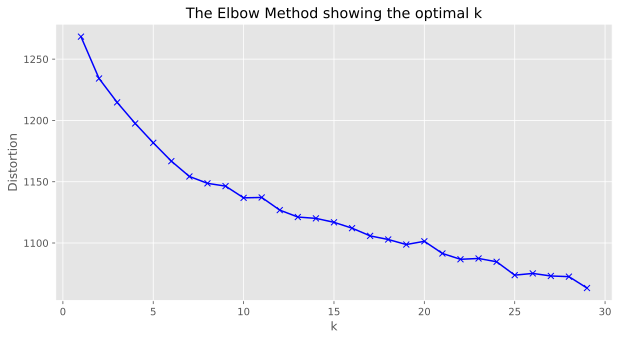

In [15]:
from sklearn.cluster import KMeans

### apply elbow method to find the optimal number of clusters from 1 to 30

distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'))
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<div dir=rtl>

<font color='yellow'>
این کد داده‌ها را به 13 خوشه تقسیم می‌کند و برچسب خوشه‌ها را به DataFrame اضافه می‌کند. این کار  اجازه می‌دهد تا ببینیم هر نمونه به کدام خوشه تعلق دارد و از این اطلاعات برای تحلیل‌های بعدی استفاده کنیم. به طور کلی، این فرآیند می‌تواند برای تحلیل خوشه‌ای، تجزیه و تحلیل اکتشافی داده‌ها، و شناسایی الگوها و گروه‌های مشابه در داده‌ها مفید باشد.
<br>
<font color='yellow'>
انتخاب تعداد خوشه‌ها:
<br>
<font color='yellow'>
بر اساس نتایج روش Elbow، تعداد خوشه‌ها 13 انتخاب شده است.
<br>
<font color='yellow'>
ایجاد مدل K-Means:
<br>
<font color='yellow'>
مدل K-Means با تعداد خوشه‌های مشخص (13) و مقدار random_state برای اطمینان از تکرارپذیری نتایج، ایجاد می‌شود.
<br>
<font color='yellow'>
آموزش مدل K-Means:
<br>
<font color='yellow'>
مدل K-Means با استفاده از داده‌های موجود در tfidf_pca_df آموزش داده می‌شود. ستون article_id در صورت وجود حذف می‌شود تا فقط داده‌های ویژگی عددی برای خوشه‌بندی استفاده شوند.
تابع fit مدل K-Means را با داده‌های tfidf_pca_df آموزش می‌دهد.
<br>
<font color='yellow'>
افزودن برچسب خوشه‌ها به DataFrame:
<br>
<font color='yellow'>
پس از آموزش مدل، برچسب‌های خوشه برای هر نمونه با استفاده از kmeans.labels_ استخراج و به عنوان یک ستون جدید به نام cluster به DataFrame tfidf_pca_df اضافه می‌شوند.
<br>
<font color='yellow'>
نمایش DataFrame به‌روز شده:
<br>
<font color='yellow'>
DataFrame tfidf_pca_df که اکنون شامل برچسب خوشه‌ها است، نمایش داده می‌شود.
<br>
</div>

In [16]:
# best number of clusters is 13 regarding the elbow method above

kmeans = KMeans(n_clusters=13, random_state=42)
kmeans.fit(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'))

# adding the cluster labels to the PCA DataFrame
tfidf_pca_df['cluster'] = kmeans.labels_

tfidf_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC951,PC952,PC953,PC954,PC955,PC956,PC957,PC958,PC959,cluster
0,0.119723,0.065268,0.079984,-0.236828,0.094082,-0.050585,0.021057,-0.003241,0.217338,0.023047,...,-0.010412,-0.015008,-0.014178,0.009260,-0.007399,0.005691,0.019139,-0.013434,0.003987,11
1,-0.250730,0.197872,0.307347,0.072249,-0.025709,0.060989,0.115094,-0.066474,-0.098095,0.084825,...,-0.025324,0.001211,-0.005614,-0.018240,0.008457,0.005622,-0.015000,0.001057,-0.003837,10
2,0.308483,-0.111703,0.184105,-0.105187,0.046082,-0.082734,0.114551,-0.052597,0.140994,0.199613,...,-0.000595,0.005860,0.007949,0.003431,0.016995,0.003550,0.002575,0.015602,-0.015437,11
3,-0.065622,0.019449,0.054963,0.006037,-0.031733,-0.038565,-0.128199,0.149893,-0.055611,-0.002084,...,-0.010139,0.025610,0.009239,0.026927,0.008300,0.013542,-0.006308,-0.019278,-0.019197,3
4,0.078273,-0.116391,0.048610,0.019842,-0.245833,-0.015016,0.065274,0.071805,-0.006330,-0.150230,...,0.011509,0.013127,0.001453,0.002497,-0.022562,0.001636,-0.000331,-0.008913,-0.015033,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.216166,-0.115107,0.100820,-0.048560,0.024996,-0.003196,0.060412,0.006417,-0.032015,0.315736,...,-0.006855,-0.018528,-0.018441,0.022852,0.003965,0.005031,-0.009335,-0.002795,-0.000721,5
1450,-0.161563,-0.081903,-0.180353,-0.014879,0.017919,-0.030956,0.057535,0.219554,-0.067498,0.277966,...,-0.005349,-0.008725,0.015207,0.011005,0.007859,0.010024,-0.022676,-0.010384,0.004823,2
1451,0.078718,0.087668,-0.026326,-0.115879,-0.032357,0.013690,-0.078774,0.026658,-0.158840,0.014747,...,-0.001172,-0.018661,-0.022077,-0.007993,-0.007495,-0.019063,0.017982,-0.003490,-0.022558,12
1452,0.067811,-0.015062,-0.009813,-0.087383,0.027344,0.041840,-0.130139,0.061009,-0.062142,0.055143,...,0.020168,0.011859,0.007951,0.014574,0.007063,0.007196,-0.012238,0.003552,-0.004192,0


In [17]:
tfidf_df['cluster'] = kmeans.labels_

In [26]:
# use dbscan for clustering

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan_clusters = dbscan.fit_predict(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'))

# add the cluster labels to the DataFrame

tfidf_pca_df['dbscan_cluster'] = dbscan_clusters

tfidf_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC952,PC953,PC954,PC955,PC956,PC957,PC958,PC959,cluster,dbscan_cluster
0,0.119723,0.065268,0.079984,-0.236828,0.094082,-0.050585,0.021057,-0.003241,0.217338,0.023047,...,-0.015008,-0.014178,0.009260,-0.007399,0.005691,0.019139,-0.013434,0.003987,11,-1
1,-0.250730,0.197872,0.307347,0.072249,-0.025709,0.060989,0.115094,-0.066474,-0.098095,0.084825,...,0.001211,-0.005614,-0.018240,0.008457,0.005622,-0.015000,0.001057,-0.003837,10,-1
2,0.308483,-0.111703,0.184105,-0.105187,0.046082,-0.082734,0.114551,-0.052597,0.140994,0.199613,...,0.005860,0.007949,0.003431,0.016995,0.003550,0.002575,0.015602,-0.015437,11,-1
3,-0.065622,0.019449,0.054963,0.006037,-0.031733,-0.038565,-0.128199,0.149893,-0.055611,-0.002084,...,0.025610,0.009239,0.026927,0.008300,0.013542,-0.006308,-0.019278,-0.019197,3,-1
4,0.078273,-0.116391,0.048610,0.019842,-0.245833,-0.015016,0.065274,0.071805,-0.006330,-0.150230,...,0.013127,0.001453,0.002497,-0.022562,0.001636,-0.000331,-0.008913,-0.015033,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.216166,-0.115107,0.100820,-0.048560,0.024996,-0.003196,0.060412,0.006417,-0.032015,0.315736,...,-0.018528,-0.018441,0.022852,0.003965,0.005031,-0.009335,-0.002795,-0.000721,5,-1
1450,-0.161563,-0.081903,-0.180353,-0.014879,0.017919,-0.030956,0.057535,0.219554,-0.067498,0.277966,...,-0.008725,0.015207,0.011005,0.007859,0.010024,-0.022676,-0.010384,0.004823,2,-1
1451,0.078718,0.087668,-0.026326,-0.115879,-0.032357,0.013690,-0.078774,0.026658,-0.158840,0.014747,...,-0.018661,-0.022077,-0.007993,-0.007495,-0.019063,0.017982,-0.003490,-0.022558,12,-1
1452,0.067811,-0.015062,-0.009813,-0.087383,0.027344,0.041840,-0.130139,0.061009,-0.062142,0.055143,...,0.011859,0.007951,0.014574,0.007063,0.007196,-0.012238,0.003552,-0.004192,0,-1


<div dir=rtl>

<font color='yellow'>
در این قسمت نیز با استفاده از dbscan و eps = 0.5 برای قسمت امتیازی خوشه بندی را انجام می‌دهیم و نتایج خوشه بندی آنرا را با نام ستون dbscan_cluster به دیتاست خود اضافه می کنیم 
<br>
</div>

In [27]:
# apply hierarchical clustering

from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=13)

agg_clusters = agg.fit_predict(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'))

# add the cluster labels to the DataFrame

tfidf_pca_df['agg_cluster'] = agg_clusters

tfidf_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC953,PC954,PC955,PC956,PC957,PC958,PC959,cluster,dbscan_cluster,agg_cluster
0,0.119723,0.065268,0.079984,-0.236828,0.094082,-0.050585,0.021057,-0.003241,0.217338,0.023047,...,-0.014178,0.009260,-0.007399,0.005691,0.019139,-0.013434,0.003987,11,-1,8
1,-0.250730,0.197872,0.307347,0.072249,-0.025709,0.060989,0.115094,-0.066474,-0.098095,0.084825,...,-0.005614,-0.018240,0.008457,0.005622,-0.015000,0.001057,-0.003837,10,-1,6
2,0.308483,-0.111703,0.184105,-0.105187,0.046082,-0.082734,0.114551,-0.052597,0.140994,0.199613,...,0.007949,0.003431,0.016995,0.003550,0.002575,0.015602,-0.015437,11,-1,8
3,-0.065622,0.019449,0.054963,0.006037,-0.031733,-0.038565,-0.128199,0.149893,-0.055611,-0.002084,...,0.009239,0.026927,0.008300,0.013542,-0.006308,-0.019278,-0.019197,3,-1,3
4,0.078273,-0.116391,0.048610,0.019842,-0.245833,-0.015016,0.065274,0.071805,-0.006330,-0.150230,...,0.001453,0.002497,-0.022562,0.001636,-0.000331,-0.008913,-0.015033,9,-1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,0.216166,-0.115107,0.100820,-0.048560,0.024996,-0.003196,0.060412,0.006417,-0.032015,0.315736,...,-0.018441,0.022852,0.003965,0.005031,-0.009335,-0.002795,-0.000721,5,-1,1
1450,-0.161563,-0.081903,-0.180353,-0.014879,0.017919,-0.030956,0.057535,0.219554,-0.067498,0.277966,...,0.015207,0.011005,0.007859,0.010024,-0.022676,-0.010384,0.004823,2,-1,12
1451,0.078718,0.087668,-0.026326,-0.115879,-0.032357,0.013690,-0.078774,0.026658,-0.158840,0.014747,...,-0.022077,-0.007993,-0.007495,-0.019063,0.017982,-0.003490,-0.022558,12,-1,7
1452,0.067811,-0.015062,-0.009813,-0.087383,0.027344,0.041840,-0.130139,0.061009,-0.062142,0.055143,...,0.007951,0.014574,0.007063,0.007196,-0.012238,0.003552,-0.004192,0,-1,11


<div dir=rtl>

<font color='yellow'>
همچنین در این قسمت نیز برای قسمت امتیازی خوشه بندی را با استفاده از روش hirearchical انجام می‌دهیم و نتایج آن را با تحت عنوان agg_cluster به دیتاست خود اضافه ‌میکنیم
<br>
</div>

In [28]:
# compare using silhouette score

from sklearn.metrics import silhouette_score

print(silhouette_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), dbscan_clusters))

print(silhouette_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), kmeans.labels_))

print(silhouette_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), agg_clusters))

print('-----------------')

# compare using calinski harabasz score

print(metrics.calinski_harabasz_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), dbscan_clusters))

print(metrics.calinski_harabasz_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), kmeans.labels_))

print(metrics.calinski_harabasz_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), agg_clusters))

print('-----------------')

# compare using davies bouldin score

print(metrics.davies_bouldin_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), dbscan_clusters))

print(metrics.davies_bouldin_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), kmeans.labels_))

print(metrics.davies_bouldin_score(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'), agg_clusters))


0.024149668289760104
0.4253596713645237
0.4253596713645237
-----------------
14.173608808168405
3794.808773482538
3794.808773482538
-----------------
0.8084838258601819
0.9698080129568574
0.9698080129568571


<div dir=rtl>

<font color='yellow'>
در این قسمت نیز نتایج ۳ خوشه بندی را با استفاده از ۳ معیار silhouette و calinski_harabasz و davies_bouldin مقایسه میکنیم.

نمره سیلوئت
نمره سیلوئت میزان شباهت یک شیء به خوشه خودش را در مقایسه با سایر خوشه‌ها اندازه‌گیری می‌کند. این نمره در بازه -1 تا 1 قرار دارد و مقدار بالاتر نشان‌دهنده خوشه‌های بهتر تعریف شده است.



نمره کالینسکی-هاراباز
نمره کالینسکی-هاراباز که به عنوان معیار نسبت واریانس نیز شناخته می‌شود، تراکم و جدایی خوشه‌ها را ارزیابی می‌کند. نمره بالاتر نشان‌دهنده خوشه‌های بهتر تعریف شده است.




نمره دیویس-بولدین
نمره دیویس-بولدین میانگین نسبت شباهت هر خوشه با خوشه‌ای که بیشترین شباهت را دارد اندازه‌گیری می‌کند. نمره پایین‌تر نشان‌دهنده خوشه‌بندی بهتر است.


تحلیل مقایسه‌ای
نمره سیلوئت:

KMeans و خوشه‌بندی تجمعی دارای نمره سیلوئت برابر با 0.4254 هستند که نشان‌دهنده خوشه‌های خوب تعریف شده است.
نمره DBSCAN برابر با 0.0241 است که نشان‌دهنده تعریف ضعیف خوشه‌ها است، که ممکن است به حساسیت آن به نویز و داده‌های پرت مرتبط باشد.


نمره کالینسکی-هاراباز:

KMeans و خوشه‌بندی تجمعی هر دو نمره بالایی برابر با 3794.81 دارند که نشان‌دهنده تراکم و جدایی خوب خوشه‌ها است.
نمره DBSCAN برابر با 14.17 است که عملکرد ضعیف‌تری در تشکیل خوشه‌های خوب تعریف شده نشان می‌دهد.


نمره دیویس-بولدین:

DBSCAN کمترین نمره دیویس-بولدین برابر با 0.8085 را دارد که نشان‌دهنده خوشه‌های فشرده‌تر و متمایزتر است.
KMeans و خوشه‌بندی تجمعی نمره‌های برابر با 0.9698 دارند که بالاتر است و نشان‌دهنده خوشه‌های نسبتاً کمتر فشرده است.



<br>
</div>

<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> t-SNE </b>
<br>
<p align="justify">
<font size=5>
t_SNE یک روش نظارت نشده غیر خطی است که برای اکتشاف و بصری‌سازی داده‌ها مورد استفاده قرار می‌گیرد.
PCA یک روش کاهش ابعاد خطی است که در تلاش برای بیشینه کردن واریانس و حفظ فاصله‌های زیاد دوتایی‌ها از یکدیگر است. این امر می‌تواند منجر به بصری‌سازی ضعیف به ویژه هنگام کار با ساختارهای غیرخطی می‌شود. t-SNE  با حفظ فاصله‌های کم دوتایی‌ها یا شباهت محلی از PCA متمایز می‌شود. به بیان ساده‌تر، t-SNE به کاربر درکی از اینکه داده‌ها چگونه در فضای ابعاد بالا سازمان‌دهی شده‌اند را ارائه می‌کند. <br>
با استفاده از t-SNE می توانیم بردار ویژگی هایی با ابعاد بالا را به 2 بعد کاهش دهیم.
در این مجموعه داده در 2 بعد می توان توزیع مقالات را با استفاده از scatterplot نمایش داد. <br>
برای تفکیک بصری موضوعات مختلف در نمودار بالا، با استفاده از خوشه هایی که در KMeans یافتید ، برای رنگ آمیزی خوشه های مختلف در مصورسازی خود میتوانید استفاده کنید.
</p>
</font>
</div>

<div dir=rtl>

<font color='yellow'>
عملکرد t-SNE بر پایه اصل دو مرحله‌ای است. در مرحله اول، t-SNE از یک ماتریس شباهت بین نمونه‌های ورودی استفاده می‌کند و احتمالات شرطی محاوره‌ها را برای هر زوج نمونه محاسبه می‌کند. این احتمالات شرطی نشان می‌دهند که چقدر احتمال دارد دو نمونه با هم در نمایش پایانی نزدیک به هم قرار بگیرند. سپس در مرحله دوم، با استفاده از یک تابع هزینه، t-SNE سعی می‌کند تا نمایشی تک بعدی یا دوبعدی را بسازد که نزدیک به احتمالات شرطی محاوره‌ها باشد.

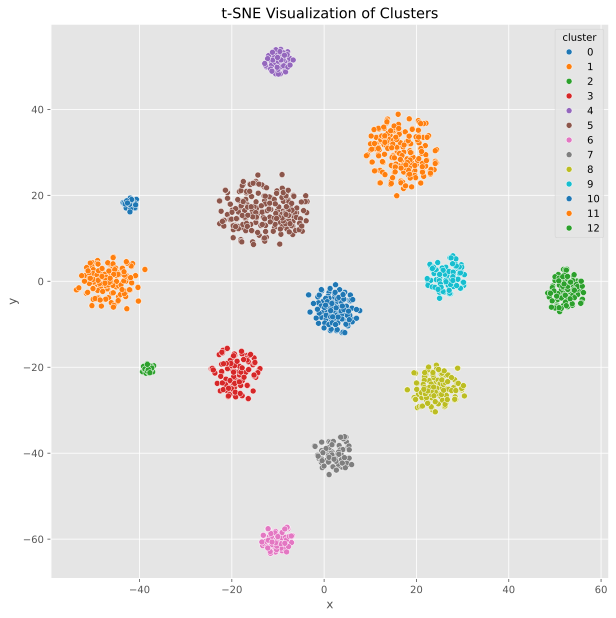

In [18]:
# Visualizing the clusters using t-SNE

tsne = TSNE(n_components=2, random_state=42)

# fit and transform the PCA DataFrame

tfidf_pca_tsne = tsne.fit_transform(tfidf_pca_df.drop(columns=['article_id'], errors='ignore'))

# create a DataFrame for the t-SNE results

tsne_df = pd.DataFrame(tfidf_pca_tsne, columns=['x', 'y'])

# add the cluster labels to the t-SNE DataFrame

tsne_df['cluster'] = tfidf_pca_df['cluster']

# plot the t-SNE results

plt.figure(figsize=(10, 10))

sns.scatterplot(x='x', y='y', hue='cluster', data=tsne_df, palette='tab10', legend='full')

plt.title('t-SNE Visualization of Clusters')

plt.show()

<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b> مدلسازی موضوعی (Topic Modeling)</b>
<br>
<p align="justify">
<font size=5>
اکنون سعی خواهیم کرد موضوعات کلیدی در هر خوشه را پیدا کنیم.
<br>
 K-means مقالات را خوشه بندی کرد اما موضوعات را برچسب گذاری نکرد. از طریق مدل‌سازی موضوع، متوجه خواهیم شد که مهمترین اصطلاحات برای هر خوشه چیست. این کار با دادن کلمات کلیدی برای شناسایی سریع مضامین خوشه، معنای بیشتری به خوشه می بخشد.<br>
برای مدلسازی موضوعی از الگوریتم های مختلفی نظیر NMF,LSA,LDA میتوان استفاده کرد.
<br>
تعداد موضوعاتی که از خوشه ها قصد دارید استخراج کنید، را به دلخواه انتخاب کنید.
<br>
با استفاده از روش (Latent Dirichlet allocation)LDA موضوعات مناسب را به تعداد موردنظر برای هر خوشه بیابید.
سپس کلمات کلیدی هر موضوع برای خوشه موردنظر را چاپ کنید.
<br><b> بخش امتیازی:</b> مدلسازی موضوعی با روشی غیر از LDA انجام دهید و موضوعات خوشه ها را در هردو روش با هم مقایسه کنید.

</p>
</font>
</div>

<div dir=rtl>

<font color='yellow'>
توضیحات:
<br>
<font color='yellow'>
تحلیل یا «آنالیز تشخیصی خطی» (Linear Discriminant Analysis - LDA) یک روش آماری برای کاهش ابعاد یک مسئله و تشخیص دسته‌ها بوسیله بیشینه‌سازی نسبت «پراکندگی بین گروه‌ها» (Scatters between groups) به «درون گروه‌ها» (Scatters within groups) است.
<br>
<font color='yellow'>
هدف از انجام آنالیز تشخیص خطی، پیدا کردن یک «تصویر» (Projection) یا «تبدیل» (Transformation) است
، روی مجموعه داده
A
 بطوری که بتواند نسبت «پراکندگی بین گروه‌ها» (Between Class) را به «پراکندگی درون گروه‌ها» (Within Class) داده‌های تبدیل شده، حداکثر کند.
<br>
<font color='yellow'>
LDA یک مدل تولیدی (generative model) است که فرض می‌کند هر سند از ترکیبی از موضوعات مختلف تشکیل شده و هر موضوع نیز از توزیع خاصی از کلمات به وجود آمده است. هدف LDA این است که با توجه به کلمات موجود در اسناد، این موضوعات پنهان را کشف کند.
<br>
<font color='yellow'>
فرآیند مدل‌سازی با LDA
<br>
<font color='yellow'>
LDA فرآیند تولیدی اسناد را به صورت زیر مدل می‌کند:
<br>
<font color='yellow'>
1. انتخاب توزیع موضوعات برای سند: برای هر سند، یک توزیع موضوعی از توزیع دیریکله انتخاب می‌شود.
<br>
<font color='yellow'>
2. انتخاب موضوع برای هر کلمه: برای هر کلمه در سند، یک موضوع با توجه به توزیع موضوعی سند انتخاب می‌شود.
<br>
<font color='yellow'>
3. انتخاب کلمه از موضوع: سپس یک کلمه از توزیع کلمات مربوط به موضوع انتخاب شده، انتخاب می‌شود.
<br>
<font color='yellow'>
LDA از یک الگوریتم تکراری (iterative) برای به‌روزرسانی توزیع‌های موضوعات و کلمات استفاده می‌کند. دو روش رایج برای انجام این به‌روزرسانی‌ها عبارتند از:

1. نمونه‌گیری گیبز (Gibbs Sampling): یک روش مونت‌کارلو مبتنی بر زنجیره مارکوف است که برای نمونه‌گیری از توزیع‌های احتمالی پیچیده استفاده می‌شود. این روش در LDA برای نمونه‌گیری از توزیع‌های موضوعات و کلمات استفاده می‌شود.
2. بهینه‌سازی واریانسی (Variational Inference): این روش از بهینه‌سازی واریانسی برای تقریب توزیع‌های پشتی (posterior distributions) استفاده می‌کند.
</div>


<div dir=rtl>

<font color='yellow'>
توضیحات کد:
<br>
<font color='yellow'>
کد در یک حلقه for از 0 تا 4 (جمعا 5 خوشه) اجرا می‌شود.
در هر تکرار از حلقه، عدد خوشه فعلی (0 تا 4) نمایش داده می‌شود.
<br>
<font color='yellow'>
فیلتر کردن DataFrame برای خوشه فعلی:
<br>
<font color='yellow'>
cluster_df شامل سطرهایی از tfidf_df است که به خوشه جاری تعلق دارند. ستون cluster حذف می‌شود تا فقط داده‌های ویژگی‌های TF-IDF باقی بمانند.
<br>
<font color='yellow'>
ایجاد و آموزش مدل LDA:
<br>
<font color='yellow'>
یک مدل LDA با 15 موضوع (تعداد موضوعات برابر با n_components=15) ایجاد می‌شود.
مدل LDA با داده‌های cluster_df آموزش داده می‌شود (fit می‌شود).
<br>
<font color='yellow'>
نمایش موضوعات برای هر خوشه:
<br>
<font color='yellow'>
در هر خوشه، موضوعات کشف شده توسط مدل LDA نمایش داده می‌شوند.
برای هر موضوع، 10 کلمه برتر (که با توجه به وزن‌هایشان مرتب شده‌اند) نمایش داده می‌شود. این کلمات بر اساس ویژگی‌های TF-IDF استخراج شده‌اند.
<br>
<font color='yellow'>
نمایش نتایج:
<br>
<font color='yellow'>
کلمات برتر هر موضوع به صورت لیست نمایش داده می‌شوند.
<br>
</div>

In [19]:
# train LDA Model on the tfidf for topic modeling for each cluster

for cluster in range(5):
    print(f'Cluster {cluster}')
    cluster_df = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns=['cluster'], errors='ignore')
    lda = LatentDirichletAllocation(n_components=15, random_state=42)
    lda.fit(cluster_df)
    for i, topic in enumerate(lda.components_):
        print(f'Topic {i}:')
        print([tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print('\n')

Cluster 0
Topic 0:
['toxic', 'hpi', 'cytotoxic', 'organ', 'disruption', 'compound', 'surfactant', 'fisher', 'smallpox', 'namely']
Topic 1:
['registered', 'compound', '2018', 'acquisition', 'manner', 'icg', 'plus', 'termed', 'diseases', 'mrnas']
Topic 2:
['plaque', 'useful', 'swabs', 'extraction', 'mathematical', 'mononuclear', 'compound', 'illness', 'usually', 'tracer']
Topic 3:
['toxins', 'file', 'concentrated', 'aerosols', 'aerosol', 'wildtype', 'transmembrane', 'participation', 'airborne', 'particle']
Topic 4:
['plaque', 'useful', 'swabs', 'extraction', 'mathematical', 'mononuclear', 'compound', 'illness', 'usually', 'tracer']
Topic 5:
['affinity', 'enzyme', 'growing', 'bind', 'chronic', 'syndromes', 'devices', 'wells', 'namely', 'antiviral']
Topic 6:
['outcomes', 'examination', 'fecal', 'disruption', 'beijing', 'washing', 'buffer', 'investigations', 'powerful', 'autopsy']
Topic 7:
['plaque', 'useful', 'swabs', 'extraction', 'mathematical', 'mononuclear', 'compound', 'illness', 'usu

In [29]:
# do topic modeling using LSA for each cluster

from sklearn.decomposition import TruncatedSVD

for cluster in range(5):
    print(f'Cluster {cluster}')
    cluster_df = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns=['cluster'], errors='ignore')
    lsa = TruncatedSVD(n_components=15, random_state=42)
    lsa.fit(cluster_df)
    for i, topic in enumerate(lsa.components_):
        print(f'Topic {i}:')
        print([tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print('\n')

# do topic modeling using NMF for each cluster

from sklearn.decomposition import NMF

for cluster in range(5):
    print(f'Cluster {cluster}')
    cluster_df = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns=['cluster'], errors='ignore')
    nmf = NMF(n_components=15, random_state=42)
    nmf.fit(cluster_df)
    for i, topic in enumerate(nmf.components_):
        print(f'Topic {i}:')
        print([tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print('\n')

Cluster 0
Topic 0:
['aerosol', 'wildtype', 'airflow', 'roles', 'venous', 'transmembrane', 'participation', 'airborne', 'particle', 'air']
Topic 1:
['directed', 'airflow', 'venous', 'vein', 'roles', 'disorders', 'gap', 'building', 'toxins', 'wildtype']
Topic 2:
['driven', 'filter', 'presents', 'green', 'efficacy', 'filters', 'namely', 'participation', 'file', 'particle']
Topic 3:
['p53', 'dust', 'room', 'presents', 'move', 'airflow', 'isolates', 'air', 'roles', 'donors']
Topic 4:
['health', 'filters', 'p53', 'surgery', 'protected', 'presents', 'smallpox', 'file', 'donors', 'wildtype']
Topic 5:
['half', 'handling', 'persistence', 'environment', 'duration', 'icg', 'carriers', 'mrnas', 'contaminated', 'diseases']
Topic 6:
['presents', 'transmembrane', 'p53', 'driven', 'efficacy', 'airborne', 'filter', 'donors', 'filters', 'file']
Topic 7:
['roles', 'wildtype', 'room', 'mrnas', 'aerosols', 'diseases', 'isolates', 'pathways', 'airborne', 'µl']
Topic 8:
['zikv', 'file', 'laboratories', 'power

/home/sina/Desktop/dm_proj_3/venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Topic 0:
['rise', 'infecting', '2014', 'arabia', 'cases', 'nose', 'health', 'saturation', 'transmembrane', 'mers']
Topic 1:
['inflammation', 'spleen', 'spinal', 'dairy', 'transfusion', 'infecting', 'luciferase', 'compatible', 'mhv', 'mers']
Topic 2:
['utilizing', 'dominant', 'infrastructure', 'done', 'mentioned', 'mers', 'pathways', 'transformed', 'controversial', 'plaque']
Topic 3:
['ill', 'migration', 'spp', 'coronary', 'virulent', 'otherwise', 'coronavirus', 'mers', 'sars', 'transmembrane']
Topic 4:
['antibodies', 'inhibitor', 'mers', 'cation', 'identical', 'ubiquitin', 'h3n2', 'resection', 'infiltration', 'substrates']
Topic 5:
['saturation', 'cdc', 'mediators', '2015', 'junction', 'independently', 'kong', 'horses', 'patient', 'mers']
Topic 6:
['assay', 'risks', 'views', 'rv', 'virulent', 'figs', 'µl', 'cells', 'hubei', 'mers']
Topic 7:
['gender', 'human', 'huh7', 'strain', 'evolution', 'phosphorylation', '4b', '4a', 'sequenced', 'mers']
Topic 8:
['restricted', 'fractions', 'fragme

/home/sina/Desktop/dm_proj_3/venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Topic 0:
['post', 'ccbyncnd', 'gramnegative', 'hmpv', 'copy', 'authorfunder', 'permeability', 'medium', 'library', 'preparedness']
Topic 1:
['medium', 'mode', 'april', 'covered', 'nucleus', 'library', 'cases', '2020', 'preparedness', 'enzymes']
Topic 2:
['severely', 'admission', 'models', 'clinical', 'several', 'medium', 'ground', 'preparedness', 'covered', 'patient']
Topic 3:
['febrile', 'loci', 'providing', 'city', 'cases', 'china', '2020', 'hsv1', 'wt', 'cities']
Topic 4:
['copy', 'permeability', 'sampled', 'sustained', '2020', 'medium', 'zoonotic', 'library', 'preparedness', 'sarscov']
Topic 5:
['hmpv', 'permeability', 'ccbyncnd', 'etc', 'medium', 'library', 'sarscov', 'preparedness', 'marrow', 'mask']
Topic 6:
['library', 'day', 'milk', 'countries', 'preparedness', 'cases', 'strategies', 'contribution', 'ibv', 'covered']
Topic 7:
['pe', 'cultures', 'counted', 'log', 'damage', 'dynamic', 'preparedness', 'morphology', 'snps', 'distance']
Topic 8:
['singlestranded', 'strict', '2020',

<div dir=rtl>

<font color='yellow'>
در این قسمت نیز برای قسمت امتیازی با استفاده از ۲ روش NMF و LSA بخش Topic modeling را انجام داده و خروجی هر بخش را مشاهده میکنیم و تفاوت آن‌هارا با یکدیگر شاهد هستیم.
<br>
</div>

<font face="B Mitra">
<div dir=rtl>
<font size=6>
<b>  مصورسازی </b>
<br>
<p align="justify">
<font size=4>
<b>این بخش شامل نمره نیست و صرفا جهت درک شما از مراحل انجام شده است</b><br>
<font size=5>
مراحل قبلی برچسب‌های خوشه‌بندی و مجموعه‌ای از مقالات را به دو بعد کاهش داده است. می‌توانیم یک طرح تعاملی از خوشه ها ایجاد کنیم. <br>
شما میتوانید با انتخاب هر خوشه از اسلایدر، توزیع هر خوشه را به صورت مجزا مشاهده کنید. همچنین میتوانید با بردن نشانگر روی هریک از نقاط مشخصات کلی آن مقاله را مشاهده کنید.
<br>
<img src="https://drive.google.com/uc?id=14xXSuD-FhmSSJBI0oH-a-DDkgjBtqj4_" alt="Linear Algebra Cover Art" width="800">
</p>
</font>
</div>

<font face="B Mitra">
<div dir=rtl>
<p align="justify">
<font size=5>
ورودی تابع زیر، دیتافریم مقالات می‌باشد که می‌بایست شامل ستون‌های زیر باشد:
<br>
1. <code>tsne-2d-one</code>: مولفهٔ اول t-SNE
<br>
2. <code>tsne-2d-two</code>: مولفهٔ دوم t-SNE
<br>
3. <code>y</code>: خوشهٔ هر یک از مقالات
</p>
</font>
</div>

In [20]:
import plotly.express as px
import plotly.graph_objects as go


In [21]:
def interactive_plot(df):
    clusters = sorted(df['y'].unique())

    # Generate distinct colors for each cluster using Plotly's colors
    colors = px.colors.qualitative.Plotly

    # Create a scatter plot for each cluster with a unique color
    data = []
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['y'] == cluster]
        scatter = go.Scatter(
            x=cluster_data['tsne-2d-one'],
            y=cluster_data['tsne-2d-two'],
            mode='markers',
            name=f'Cluster {cluster}',
            text=cluster_data['title'],
            hoverinfo='text',
            marker=dict(size=10, color=colors[i % len(colors)]),  # Assign a unique color
            visible=False  # Initially, make all traces invisible
        )
        data.append(scatter)

    # Add a scatter plot for all clusters with different colors
    scatter_all = go.Scatter(
        x=df['tsne-2d-one'],
        y=df['tsne-2d-two'],
        mode='markers',
        name='All Clusters',
        text=df['title'],
        hoverinfo='text',
        marker=dict(size=10, color=df['y'].map(lambda x: colors[x % len(colors)])),  # Assign colors by cluster
        visible=True  # Initially, show all clusters
    )
    data.append(scatter_all)

    x_min = df['tsne-2d-one'].min()
    x_max = df['tsne-2d-one'].max()
    y_min = df['tsne-2d-two'].min()
    y_max = df['tsne-2d-two'].max()

    # Initialize the figure
    fig = go.Figure(data=data)

    # Ensure square aspect ratio
    fig.update_layout(
        title='Cluster Visualization',
        xaxis=dict(title='t-SNE 1', range=[x_min, x_max]),  # Ensure x and y axes are equal
        yaxis=dict(title='t-SNE 2', range=[y_min, y_max]),
        width=1000,
        height=700  # Ensure the figure is square-shaped
    )

    # Add hover functionality
    fig.update_traces(
        hoverinfo='text',
        marker=dict(opacity=0.7, size=8),
    )

    # Add interactive slider for cluster selection
    steps = []
    for i, cluster in enumerate(clusters):
        step = dict(
            method='update',
            args=[{'visible': [False] * len(clusters) + [False]},  # Hide all clusters
                {'title': f'Cluster {cluster}'}],
            label=f'Cluster {cluster}'
        )
        # Only make the current cluster visible
        step['args'][0]['visible'][i] = True
        steps.append(step)

    # Add final step for all clusters
    steps.append(dict(
        method='update',
        args=[{'visible': [False] * len(clusters) + [True]},  # Only show the 'all clusters' trace
            {'title': 'All Clusters'}],
        label='All Clusters'
    ))

    sliders = [dict(
        active=len(steps) - 1,
        currentvalue={"prefix": "Cluster: "},
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders
    )

    # Display the plot
    fig.show()

In [22]:
tsne_df['x']

0       16.638964
1        5.157310
2       18.549051
3      -16.707073
4       26.456594
          ...    
1449   -11.949781
1450   -38.286812
1451    52.731823
1452   -42.604511
1453   -17.900536
Name: x, Length: 1454, dtype: float32

In [23]:
visulization_df = df.copy()
visulization_df['tsne-2d-one'] = tsne_df['x'].values
visulization_df['tsne-2d-two'] = tsne_df['y'].values
visulization_df['y'] = kmeans.labels_

In [24]:
visulization_df

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,tokens,processed_text,tsne-2d-one,tsne-2d-two,y
6252,fefd6cdcddcb00d1ba2ef1a0d3bba9f312010a1d,10.1111/j.1524-4733.2008.00379.x,,China is the biggest country in the world that...,"Li, Youing. Sun, Xin. Wang, Li",Evidence-Based Medicine in China,Value in Health,Not provided.,en,"[china, biggest, country, world, 13, billion, ...",china biggest country world 13 billion populat...,16.638964,23.411583,11
4684,2a3d080d5dcf6771db002366691f35e5d6f0e493,10.1007/s13238-010-0029-7,,"✉ Correspondence: zlshi@wh.iov.cn Bat, the onl...","Shi, Zhengli",Bat and virus,Protein & Cell,Not provided.,en,"[correspondence, zlshiwhiovcn, bat, flying, ma...",correspondence zlshiwhiovcn bat flying mammal ...,5.157310,-10.124955,10
1731,2de657aabab331e75657bfc1443542fd345b6f26,10.1016/j.ccc.2019.06.001,KEYWORDS\nPandemic Influenza Disaster prepared...,Outbreaks of infectious disease pose unique ch...,"Maves, Ryan C.. Jamros, Christina M.. Smith...",Intensive Care Unit Preparedness During<br>Pa...,Crit Care Clin,KEYWORDS\nPandemic Influenza Disaster<br>prep...,en,"[outbreaks, infectious, disease, pose, unique,...",outbreaks infectious disease pose unique chall...,18.549051,31.943220,11
4742,bc22758234283f024f16e2dbe660bc909b512b92,10.1016/j.vetpar.2007.11.020,Cryptosporidium parvum is recognized as one of...,Diarrhoeal diseases of infectious aethiology r...,"Klein, Pavel. Kleinová, Tereza. Volek,<br>Z...",Effect of Cryptosporidium parvum infection on...,Veterinary Parasitology,Cryptosporidium parvum is recognized as one o...,en,"[diarrhoeal, diseases, infectious, aethiology,...",diarrhoeal diseases infectious aethiology repr...,-16.707073,-17.563341,3
4521,a204aafa38365dbcc0a26af3ca2c6d3313d7fab2,10.1111/irv.12518,", Brazil, in the period of Background: The res...",The inclusion criteria for asymptomatic adults...,"Moreira, Luciana Peniche. Watanabe, Aripuana...",Respiratory syncytial virus evaluation among<...,Influenza Other Respir Viruses,", Brazil, in the period of Background: The<br...",en,"[inclusion, criteria, asymptomatic, adults, ab...",inclusion criteria asymptomatic adults absence...,26.456594,1.074980,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,e021d75c9a2c8f02f80ccfbad4133b15d1777576,10.1038/sj.eye.6701885,Many new infectious diseases in humans have be...,Severe acute respiratory syndrome (SARS) is th...,"Chan, W-M. Liu, D T L. Chan, P K S. Chong,...",Precautions in ophthalmic practice in a<br>ho...,Eye (Lond),Many new infectious diseases in humans have<b...,en,"[severe, acute, respiratory, syndrome, sars, m...",severe acute respiratory syndrome sars modern ...,-11.949781,16.804514,5
6043,24beb94c313a07be6b0c745a6ca8a3d810618506,,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome (MERS) is...,"Ozharovskaia, T. A.. Zubkova, O. V.. <br>Dol...",Immunogenicity of Different Forms of Middle<b...,Acta Naturae,The Middle East respiratory syndrome<br>coron...,en,"[middle, east, respiratory, syndrome, mers, ac...",middle east respiratory syndrome mers acute in...,-38.286812,-19.332333,2
6879,94475eaa419b11d7edf53c2fe4e423acef0ce881,10.12688/wellcomeopenres.15718.1,The current novel coronavirus outbreak appears...,The ongoing outbreak of novel Coronavirus appe...,"Abbott, Sam. Hellewell, Joel. Munday, James...",The transmissibility of novel Coronavirus in<...,Wellcome Open Res,The current novel coronavirus outbreak<br>app...,en,"[ongoing, outbreak, novel, coronavirus, appear...",ongoing outbreak novel coronavirus appears ori...,52.731823,1.140542,12
6775,a6ab8b27158a48683b4fa6d081614cde9087cc5e,10.1016/j.bja.2020.05.002,,Editor -The critical shortage of medical suppl...,"Lang, Angela L.. Shaw, Kendrick M.. Lozano,...",Effectiveness of a negative-pressure patient<...,Br. j. anaesth,Not provided.,en,"[editor, the, critical, shortage, medical, sup...",editor the critical shortage medical supplies ...,-42.604511,18.217789

In [25]:
interactive_plot(visulization_df)